In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 300)
pd.set_option('max_columns', 200)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

startDate = '20201207'
endDate = '20201216'

readPath = r'\\192.168.10.28\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]

rawOrderLog = []
for thisPath in dataPathLs:
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].fillna(0).astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

if rawOrderLog[rawOrderLog.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                    'orderDirection', 'absOrderSize'], keep=False)].shape[0] != 0:
    display('There are accounts with duplicated ticks:')
    display(rawOrderLog[rawOrderLog.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                    'orderDirection', 'absOrderSize'], keep=False)]\
.groupby(['date', 'colo', 'accCode'])['ars'].size())
    rawOrderLog = rawOrderLog.drop_duplicates(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                    'orderDirection', 'absOrderSize'], keep='first')

display('There are ticks with orderDirection 0')
display(rawOrderLog[rawOrderLog['orderDirection'] == 0][['date', 'colo', 'accCode', \
            'secid', 'vai', 'updateType', 'sdd', 'orderDirection', 'absOrderSize', 'internalId', 'orderId']])

assert(rawOrderLog[rawOrderLog['updateType'] == 0][rawOrderLog[rawOrderLog['updateType'] == 0]\
                                                   .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                'vai', 'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
try:
    assert(rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)][rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
except:
    print('There are orders with all things same except sdd')
    print(rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)][rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'absOrderSize', 'internalId'], keep=False)])
    assert(rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)][rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] != 8856)]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'absOrderSize', 'internalId', 'sdd'], keep=False)].shape[0] == 0)
try:
    assert(sum(rawOrderLog[(rawOrderLog['updateType'] != 0) & (rawOrderLog['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() != 1) == 0) 
except:
    print('There are orders with same internalId but different orderId other than accCode 8856 case')
    print(rawOrderLog[(rawOrderLog['updateType'] != 0) & (rawOrderLog['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique()[rawOrderLog[(rawOrderLog['updateType'] != 0) & (rawOrderLog['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() > 1])

r2 = rawOrderLog[(rawOrderLog['accCode'] != 8856) & (rawOrderLog['orderDirection'] != 0)]
r1 = rawOrderLog[(rawOrderLog['accCode'] == 8856) & (rawOrderLog['orderDirection'] != 0)]
r1['test'] = r1.groupby(['date', 'colo', 'accCode', 'secid', 
            'orderDirection', 'absOrderSize']).grouper.group_info[0]
r1 = r1.sort_values(by=['test', 'clockAtArrival'])
r1.loc[r1['updateType'] != 0, 'vai'] = np.nan
r1['vai'] = r1.groupby('test')['vai'].ffill()
r2['test'] = r2.groupby(['date', 'colo', 'accCode', 'secid', 
            'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]
r2 = r2.sort_values(by=['test', 'clockAtArrival'])
r2.loc[r2['updateType'] != 0, 'vai'] = np.nan
r2['vai'] = r2.groupby('test')['vai'].ffill()
assert(sum(r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
try:
    assert(sum(r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
except:
    a = r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique()[r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1].reset_index()
    print(pd.merge(r2, a[['test', 'vai']], on=['test', 'vai'], how='inner')[['secid', 'accCode', 'colo', 'vai', 'updateType', 'sdd', 'internalId', 'orderId', 'absOrderSize', 'absFilledThisUpdate', 'absOrderSizeCumFilled', 'orderPrice', 'tradePrice']])
orderLog = pd.concat([r1, r2])
del r1
del r2    

orderLog = orderLog.sort_values(by=['date', 'colo', 'accCode', 'secid', 'vai', 'clockAtArrival']).reset_index(drop=True)
orderLog['clock'] = orderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
orderLog['broker'] = orderLog['accCode'] // 100
orderLog["broker"] = np.where(orderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), orderLog['accCode'] // 10000, orderLog["broker"])
orderLog['colo_broker'] = orderLog['colo'].str[:2] + '_' + orderLog['broker'].astype('str')
orderLog['order'] = orderLog.groupby(['date', 'colo', 'accCode', 'secid', 'vai']).grouper.group_info[0]
orderLog['group'] = orderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
orderLog['startClock'] = orderLog.groupby(['order'])['clockAtArrival'].transform('first')
orderLog['duration'] = orderLog['clockAtArrival'] - orderLog['startClock']
orderLog['orderPrice'] = orderLog['orderPrice'].apply(lambda x: round(x, 2))
orderLog['tradePrice'] = orderLog['tradePrice'].apply(lambda x: round(x, 2))
orderLog['orderDirection1'] = np.where(orderLog["orderDirection"] == -2, -1, np.where(
    orderLog["orderDirection"] == 2, 1, orderLog["orderDirection"]))
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')


### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)].groupby(['accCode'])['orderDirection'].size())
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'colo', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    display(a.groupby(['accCode'])['date'].size())
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby(['date', 'accCode'])['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby(['date', 'accCode'])['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby(['date', 'accCode'])['order'].nunique().reset_index()
k2 = orderLog.groupby(['date', 'accCode'])['order'].nunique().reset_index()
k = pd.merge(k1, k2, on=['date', 'accCode'], how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure all CYB stocks have absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks order size < 30w')
try:
    cyb = orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)].groupby('date')['absOrderSize'].max().reset_index()
    assert(cyb[cyb['absOrderSize'] > 300000].shape[0] == 0)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog["mrsb90"] = orderLog.groupby(['order'])['mrsb90'].transform('first')
orderLog["mrss90"] = orderLog.groupby(['order'])['mrss90'].transform('first')
orderLog["mrstaat"] = orderLog.groupby(['order'])['mrstaat'].transform('first')
orderLog["mrstauc"] = orderLog.groupby(['order'])['mrstauc'].transform('first')
orderLog["aaa"] = orderLog.groupby(['order'])['aaa'].transform('first')

orderLog['m1'] = orderLog['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
orderLog['m2'] = orderLog['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
if orderLog[orderLog['mrsb90'] == '-'].shape[0] != 0:
    display(orderLog[orderLog['mrsb90'] == '-'])
orderLog = orderLog[orderLog['mrsb90'] != '-']
orderLog['mrsb90'] = orderLog['mrsb90'].astype(float)
if orderLog[orderLog['aaa'] == '-'].shape[0] != 0:
    display(orderLog[orderLog['aaa'] == '-'])
orderLog = orderLog[orderLog['aaa'] != '-']
orderLog['aaa'] = orderLog['aaa'].astype(float)
orderLog.loc[(orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'mrstauc'] = \
orderLog.loc[(orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'm2']

orderLog.loc[(orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'mrstaat'] = \
orderLog.loc[(orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'm1']

orderLog.loc[(orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'mrstauc'] = \
orderLog.loc[(orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'm2']

orderLog.loc[(orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'mrstaat'] = \
orderLog.loc[(orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'm1']    

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["mrstaat"] = orderLog.groupby(['order'])['mrstaat'].transform('first')
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog["mrstauc"] = orderLog.groupby(['order'])['mrstauc'].transform('first')
orderLog = orderLog[~orderLog['ars'].isnull()]
orderLog['sta'] = np.where(orderLog['mrstaat'] == 1000, '1. staone', np.where(
orderLog['mrstaat'] == 3000, '2. statwo', np.where(
orderLog['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
display(orderLog[orderLog['sta'] == 'else'][['date', 'secid', 'colo', 'accCode', 'updateType', 'vai', 'absOrderSize', 'orderDirection', 'mrstaat', 'mrstauc', 'sdd', 'ApplSeqNum', 'sta']])
orderLog = orderLog[orderLog['mrstaat'].isin([11000, 13000, 1000, 3000])]
display(orderLog[orderLog['updateType'] == 0].groupby(['mrstaat', 'mrstauc'])['date'].size())

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (54,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (38,39,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=resu

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
251006,20201207,zs_54_01,5474,2000565,-1,1,52618.0,0,0,-1.0,8.689164e+08
271922,20201207,zs_96_08,9685,2000802,-1,7,40338.0,0,0,-1.0,-1.000000e+00
316660,20201207,zs_66_01,6634,2002177,-1,1,50844.0,0,0,-1.0,1.812809e+10
350323,20201207,zs_52_08,5281,2002410,-1,1,34461.0,0,0,-1.0,1.105800e+05
369671,20201207,zs_52_06,5269,2002553,-1,1,35149.0,0,0,-1.0,2.627480e+05
405701,20201207,zs_66_01,6634,2002753,-1,1,51509.0,0,0,-1.0,1.812809e+10
415422,20201207,zs_52_06,5269,2002808,-1,1,34995.0,0,0,-1.0,2.344340e+05
473560,20201207,zs_52_06,5269,2300175,-1,1,40457.0,0,0,-1.0,8.723280e+05
495446,20201207,zs_52_09,5291,2300296,-1,1,39960.0,0,0,-1.0,8.262520e+05
528555,20201207,zs_94_05,9454,2300468,-1,7,37155.0,0,0,-1.0,-1.000000e+00


There are orders with all things same except sdd
         ApplSeqNum       aaa  absFilledThisUpdate  absOrderSize  \
5137081   3686264.0   0.00044                    0           100   
5137362  18252604.0  0.001406                    0           100   
5169063   3688220.0  0.000419                    0           100   
5169086  14404537.0  0.000657                    0           100   

         absOrderSizeCumFilled  accCode  ars  caamd  cancellationPending  \
5137081                      0   966301  0.0      0                  0.0   
5137362                      0   966301  0.0      0                  0.0   
5169063                      0   966301  0.0      0                  0.0   
5169086                      0   966301  0.0      0                  0.0   

               cfe         clock    clockAtArrival  cumSharesBought  \
5137081  506777.82  1.608083e+15  1608083268955951            100.0   
5137362  147834.78  1.608101e+15  1608101490951270              0.0   
5169063  568630.

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


accCode
5229        9
5230        1
5232        1
5264        1
5269        1
5275        8
5276        4
5287        2
5289        5
5290        1
5291        1
5332        6
5377       15
5384        2
5386        8
5456      133
5470        2
6237      310
6282      295
6623        1
6627        3
6683        5
8833        3
8854       21
8865        4
8886       11
8924       11
8967        2
9248        2
9441      112
9448        3
9451        1
9461        4
9655        1
9685        2
9754       14
9756        1
9758      137
9765        2
522201      2
522401      6
522601      7
523001      5
527101      3
527301      5
527601      1
527701      1
528401      1
528701      3
528901      2
537403      8
537501      1
896702      8
897002      3
965801      3
966301      1
966501      2
968501      1
975601      2
Name: orderDirection, dtype: int64

2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,colo,accCode,secid,vai,order,clockAtArrival
0,20201207,zs_52_06,5273,2300585,10000.0,10391,2
1,20201207,zs_54_01,5456,2300552,343240.0,45272,2
2,20201207,zs_54_01,5456,2300573,365988.0,45300,2
3,20201207,zs_54_01,5456,2300788,625805.0,45511,2
4,20201207,zs_96_06,9758,2002959,192600.0,86882,2
5,20201207,zs_96_06,9758,2300552,343240.0,87813,2
6,20201207,zs_96_06,9758,2300573,365988.0,87860,2
7,20201207,zs_96_08,6237,2300257,1822963.0,93286,2
8,20201207,zt_88_06,8854,2300149,3823915.0,136504,2
9,20201207,zt_94_06,9441,1603338,1072665.0,147836,2


accCode
5225       4
5226       1
5230       1
5269       1
5273       4
5275       1
5456      36
5474       1
6237      36
6282      34
6634       1
8854       9
8886       3
9441      16
9451       3
9461       5
9741       1
9756       1
9758      48
522201     1
522401     2
522601     1
522901     1
523001     2
526901     2
527301     1
527601     1
527701     3
528101     2
528401     1
528701     1
528901     2
529001     1
529101     2
966301     1
966701     1
974101     4
Name: date, dtype: int64

99.47% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
5661,7991,23600,24700
14658,20210,500,1600
18312,24815,123700,125500
23812,32230,3900,4600
29890,39905,3000,22800
30351,40497,2600,3100
32681,43580,26100,30800
37468,49887,1200,1600
38552,51563,300,600
41138,54971,1000,2600


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,ApplSeqNum,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,date,finalState,gfe,hee,insertedShortOrder,insertionPending,internalId,inv_L,inv_L0,inv_S,inv_S0,l4tr,locateShares,locateSharesTotal,mfe,mra100,mrb100,mrm,mrm25,mrmum,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,mrv,ms,mse,mt,mta,mv,orderDirection,orderId,orderOutstanding,orderPrice,orderSysId,sdd,secid,sequenceNo,session,threadId,totalActions,totalCanceled,tradeId,tradePrice,underlyingIndex,updateType,vai,zipFile,colo,l4algoDebug,test,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


,date,secid,colo,accCode,updateType,vai,absOrderSize,orderDirection,mrstaat,mrstauc,sdd,ApplSeqNum,sta
126894,20201207,1601686,zt_88_06,8854,0,302.0,735,-1,0.0,0.0,134146000.0,0.0,else
126895,20201207,1601686,zt_88_06,8854,2,302.0,735,-1,0.0,0.0,-1.0,0.0,else
126896,20201207,1601686,zt_88_06,8854,4,302.0,735,-1,0.0,0.0,-1.0,0.0,else
126897,20201207,1601686,zt_88_06,8886,0,302.0,735,-1,0.0,0.0,134146000.0,0.0,else
126898,20201207,1601686,zt_88_06,8886,2,302.0,735,-1,0.0,0.0,-1.0,0.0,else
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374435,20201216,2300595,zt_96_01,966301,1,1490268.0,100,1,0.0,0.0,95950410.0,0.0,else
5374436,20201216,2300595,zt_96_01,966301,3,1490268.0,100,1,0.0,0.0,-1.0,0.0,else
5375327,20201216,2300595,zt_96_01,966301,0,4393631.0,100,1,0.0,0.0,135327880.0,15075042.0,else
5375328,20201216,2300595,zt_96_01,966301,2,4393631.0,100,1,0.0,0.0,-1.0,0.0,else


mrstaat  mrstauc
1000.0   0.0        189889
3000.0   1000.0     921887
         2000.0      62527
         3000.0      23310
11000.0  10000.0      7156
         20000.0       538
         30000.0       367
13000.0  11000.0    149080
         12000.0      5595
         13000.0      1333
         21000.0      3517
         22000.0      4314
         23000.0       891
         31000.0      1681
         32000.0      1515
         33000.0      1928
Name: date, dtype: int64

In [3]:
orderLog = orderLog[orderLog['ars']%10 == 1]
orderLog['server_account'] = orderLog['colo'].apply(lambda x: x.replace('_', '')) + '_' + orderLog['accCode'].astype(str)
orderLog[(orderLog['sta'].isin(['3. sta300'])) & (orderLog['updateType'] == 0)].groupby(['date', 'server_account'])['secid'].nunique()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date      server_account
20201207  zs8804_8924       194
          zs8804_892402       1
          zs8804_8967       178
          zs8804_896702     131
          zs9606_9756       508
          zs9606_975601     273
          zs9606_9765       206
          zt5205_537403      79
          zt8806_8943       153
          zt9406_9551       145
20201208  zs8804_8924       162
          zs8804_8967       194
          zs8804_896702     111
          zs9606_9756       432
          zs9606_975601     242
          zs9606_9765       158
          zt5205_537403      74
          zt8806_8943       128
          zt9406_9551        99
20201209  zs8804_8924       253
          zs8804_8967        88
          zs8804_896702     172
          zs9606_9756       679
          zs9606_975601     356
          zs9606_9765       176
          zt5205_537403     121
          zt8806_8854         1
          zt8806_8943       139
          zt9406_9551       176
20201210  zs8804_8924       203
          zs880

In [42]:
import pymongo
import io
import pandas as pd
import pickle
import datetime
import time
import gzip
import lzma
import pytz
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    

database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)
memb1 = read_memb_daily(db1, 'index_memb', 20201211, 20201211)

In [43]:
display(orderLog[(orderLog['server_account'] == 'zt8803_897002') & (orderLog['date'] == 20201214) & (orderLog['sta'] == '3. sta300')]['secid'].max())
display(set(orderLog[(orderLog['server_account'] == 'zt8803_897002') & (orderLog['date'] == 20201214) & (orderLog['sta'] == '3. sta300')]['secid'].unique()) - \
set(memb[memb['index_name'] == 'IC']['skey'].unique()))

1603883

set()

In [55]:
checkLog1 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] < 20201214)],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] < 20201215)]])
checkLog2 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] >= 20201214) & (orderLog['sta'] == '3. sta300')],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] >= 20201215) & (orderLog['sta'] == '3. sta300')]])
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog = checkLog[(checkLog["updateType"] == 0)]
checkLog['index'] = np.where(checkLog['server_account'].isin(['zt5205_537501', 'zs5206_5384']), 'IF', np.where(
checkLog['server_account'].isin(['zt8803_897002', 'zt8806_8886']), 'IC', np.where(
checkLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683']), 'CSI1000', 'CSIRest')))
# display(checkLog.groupby(['date', 'tag', 'index'])['server_account'].unique())
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['nn'] = checkLog.groupby(['exchange', 'server_account', 'secid'])['tag'].transform('nunique')
checkLog = checkLog[checkLog['nn'] == 2]
checkLog['broker'] = checkLog['colo'].str[:2] + '_' + checkLog['accCode'].astype(str).str[:2]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
re = checkLog.groupby(['tag', 'index', 'broker'])['internal_latency'].describe().reset_index()
re = re[['tag', 'index', 'broker', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
re = re.fillna(0)
for i in re.columns[(re.columns != 'tag') & (re.columns != 'broker') & (re.columns != 'index')]:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['index', 'broker', 'tag'])[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

In [7]:
checkLog1 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] < 20201214)],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] < 20201215)]])
checkLog2 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] >= 20201214) & (orderLog['sta'] == '3. sta300')],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] >= 20201215) & (orderLog['sta'] == '3. sta300')]])
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog = checkLog[(checkLog["updateType"] == 0)]
checkLog['nn'] = checkLog.groupby(['exchange', 'server_account', 'secid'])['tag'].transform('nunique')
checkLog = checkLog[checkLog['nn'] == 2]
save = checkLog.groupby(['server_account', 'secid'])['date'].size().reset_index()

checkLog1 = orderLog[(orderLog['secid'].isin(checkLog['secid'].unique())) & (orderLog['updateType'] == 0)]
checkLog1['brokerNum'] = checkLog1.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog1['num'] = np.where(checkLog1['brokerNum'] == 1, '0', np.where(
(checkLog1['brokerNum'] >= 2) & (checkLog1['brokerNum'] <= 3), '1-2', '>2'))
c1 = pd.concat([checkLog1[(checkLog1['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (checkLog1['date'] < 20201214)],
                       checkLog1[(checkLog1['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (checkLog1['date'] < 20201215)]])
c2 = pd.concat([checkLog1[(checkLog1['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (checkLog1['date'] >= 20201214) & (checkLog1['sta'] == '3. sta300')],
                       checkLog1[(checkLog1['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (checkLog1['date'] >= 20201215) & (checkLog1['sta'] == '3. sta300')]])
c1['tag'] = 'before rollout'
c2['tag'] = 'after rollout'
checkLog1 = pd.concat([c1, c2])
checkLog1 = pd.merge(checkLog1, save[['server_account', 'secid']], on=['server_account', 'secid'])
checkLog1['index'] = np.where(checkLog1['server_account'].isin(['zt5205_537501', 'zs5206_5384']), 'IF', np.where(
checkLog1['server_account'].isin(['zt8803_897002', 'zt8806_8886']), 'IC', np.where(
checkLog1['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683']), 'CSI1000', 'CSIRest')))
checkLog1['broker'] = checkLog1['colo'].str[:2] + '_' + checkLog1['accCode'].astype(str).str[:2]

re = checkLog1.groupby(['index', 'broker', 'tag', 'num'])['date'].size().reset_index()
re = pd.pivot_table(re, values=['date'], columns=['num'], index=['index', 'broker', 'tag']).reset_index()
re['date', 'sum'] = re['date', '0'] + re['date', '1-2'] + re['date', '>2']
re['date', '0'] = re['date', '0'] / re['date', 'sum']
re['date', '1-2'] = re['date', '1-2'] / re['date', 'sum']
re['date', '>2'] = re['date', '>2'] / re['date', 'sum']
re['date', '0'] = re['date', '0'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '1-2'] = re['date', '1-2'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '>2'] = re['date', '>2'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re.groupby(['index', 'broker', 'tag'])[[('date',   '0'), ('date', '1-2'), ('date', '>2')]].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [6]:
checkLog = orderLog[(orderLog['updateType'] == 0)]
sec_list = set(checkLog[(checkLog['server_account'] == 'zt8803_897002') & (checkLog['date'] < 20201214)]['secid'].unique()) & \
set(checkLog[(checkLog['server_account'] == 'zt8803_897002') & (checkLog['date'] >= 20201214) & (checkLog['sta'] == '3. sta300')]['secid'].unique()) 
print(len(sec_list))
check = orderLog[(orderLog['secid'].isin(sec_list)) & (orderLog['updateType'] == 0)]
check['brokerNum'] = check.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
check['num'] = np.where(check['brokerNum'] == 1, '0', np.where(
(check['brokerNum'] >= 2) & (check['brokerNum'] <= 3), '1-2', '>2'))
check[(check['server_account'] == 'zt8803_897002') & (check['date'] < 20201214)].groupby(['num'])['date'].size()

105


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


num
0      1792
1-2    1481
>2      477
Name: date, dtype: int64

In [8]:
1481 / (1792 + 1481 + 477)

0.39493333333333336

In [73]:
checkLog1 = orderLog[(orderLog['updateType'] == 0)]
checkLog1['tag'] = np.where((checkLog1['date'] >= 20201214), 'after rollout', 'before rollout')
checkLog1['nn'] = checkLog1.groupby(['server_account', 'secid'])['tag'].transform('nunique')
checkLog1 = checkLog1[checkLog1['nn'] == 2]
checkLog1['brokerNum'] = checkLog1.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog1['num'] = np.where(checkLog1['brokerNum'] == 1, '0', np.where(
(checkLog1['brokerNum'] >= 2) & (checkLog1['brokerNum'] <= 3), '1-2', '>2'))
checkLog1 = checkLog1[checkLog1['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])]
re = checkLog1.groupby(['tag', 'num'])['date'].size().reset_index()

re = pd.pivot_table(re, values=['date'], columns=['num'], index='tag').reset_index()
re['date', 'sum'] = re['date', '0'] + re['date', '1-2'] + re['date', '>2']
re['date', '0'] = re['date', '0'] / re['date', 'sum']
re['date', '1-2'] = re['date', '1-2'] / re['date', 'sum']
re['date', '>2'] = re['date', '>2'] / re['date', 'sum']
re['date', '0'] = re['date', '0'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '1-2'] = re['date', '1-2'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '>2'] = re['date', '>2'].apply(lambda x: '%.1f%%'%(100*x))
re.groupby(['tag'])[[('date',   '0'), ('date', '1-2'), ('date', '>2')]].first()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


date              
num                 0    1-2     >2
tag                                
after rollout   39.1%  43.9%  17.0%
before rollout  35.3%  45.4%  19.3%

In [54]:
checkLog1 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] < 20201214)],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] < 20201215)]])
checkLog2 = pd.concat([orderLog[(orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002'])) & (orderLog['date'] >= 20201214) & (orderLog['sta'] == '3. sta300')],
                       orderLog[(orderLog['server_account'].isin(['zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (orderLog['date'] >= 20201215) & (orderLog['sta'] == '3. sta300')]])
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog['count'] = checkLog.groupby(['exchange', 'server_account', 'secid'])['tag'].transform('nunique')
checkLog = checkLog[checkLog['count'] == 2]
checkLog['index'] = np.where(checkLog['server_account'].isin(['zt5205_537501', 'zs5206_5384']), 'IF', np.where(
checkLog['server_account'].isin(['zt8803_897002', 'zt8806_8886']), 'IC', np.where(
checkLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683']), 'CSI1000', 'CSIRest')))
checkLog['broker'] = checkLog['colo'].str[:2] + '_' + checkLog['accCode'].astype(str).str[:2]

d1 = checkLog[(checkLog['updateType'] == 0)].groupby(['index', 'broker', 'tag', 'exchange'])['orderNtl'].sum().reset_index()
d2 = checkLog[(checkLog['updateType'] == 4)].groupby(['index', 'broker', 'tag', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['index', 'broker', 'tag', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange','index', 'broker', 'tag'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [56]:
test_data = []
for server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']:
    cc = orderLog[orderLog['secid'].isin(checkLog[checkLog['server_account'] == server]['secid'].unique())]
    cc = cc[(~cc['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']))]
    cc['tag'] = 'before rollout'
    if server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002']:
        date = 20201214
    else:
        date = 20201215
    cc.loc[(cc['date'] >= date), 'tag'] = 'after rollout'
    cc['num'] = cc.groupby(['exchange', 'server_account', 'secid', 'sta'])['tag'].transform('nunique')
    cc = cc[cc['num'] == 2]
    if server in ['zt5205_537501', 'zs5206_5384']:
        cc['index'] = 'IF'
    elif server in ['zt8803_897002', 'zt8806_8886']:
        cc['index'] = 'IC'
    elif server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683']:
        cc['index'] = 'CSI1000'
    else:
        cc['index'] = 'CSIRest'
    cc['server'] = server
    test_data += [cc]
test_data = pd.concat(test_data)
test_data['broker'] = test_data['server'].apply(lambda x: x[:2] + '_' + x.split('_')[1][:2])
d1 = test_data[(test_data['updateType'] == 0)].groupby(['index', 'broker', 'tag', 'exchange'])['orderNtl'].sum().reset_index()
d2 = test_data[(test_data['updateType'] == 4)].groupby(['index', 'broker', 'tag', 'exchange'])['tradeNtl'].sum().reset_index()
re3 = pd.merge(d1, d2, on=['index', 'broker', 'tag', 'exchange'])
re3['fill rate'] = re3['tradeNtl'] / re3['orderNtl']
re3['fill rate'] = re3['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re3.groupby(['exchange','index', 'broker', 'tag'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [58]:
test_data = []
for server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']:
    cc = orderLog[orderLog['secid'].isin(checkLog[checkLog['server_account'] == server]['secid'].unique())]
    cc = cc[(~cc['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']))]
    cc['tag'] = 'before rollout'
    if server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002']:
        date = 20201214
    else:
        date = 20201215
    cc.loc[(cc['date'] >= date), 'tag'] = 'after rollout'
    cc['num'] = cc.groupby(['exchange', 'server_account', 'secid'])['tag'].transform('nunique')
    cc = cc[cc['num'] == 2]
    if server in ['zt5205_537501', 'zs5206_5384']:
        cc['index'] = 'IF'
    elif server in ['zt8803_897002', 'zt8806_8886']:
        cc['index'] = 'IC'
    elif server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683']:
        cc['index'] = 'CSI1000'
    else:
        cc['index'] = 'CSIRest'
    cc['server'] = server
    test_data += [cc]
test_data = pd.concat(test_data)
test_data['broker'] = test_data['server'].apply(lambda x: x[:2] + '_' + x.split('_')[1][:2])
d1 = test_data[(test_data['updateType'] == 0)].groupby(['index', 'broker', 'tag', 'exchange'])['orderNtl'].sum().reset_index()
d2 = test_data[(test_data['updateType'] == 4)].groupby(['index', 'broker', 'tag', 'exchange'])['tradeNtl'].sum().reset_index()
re4 = pd.merge(d1, d2, on=['index', 'broker', 'tag', 'exchange'])
re4['fill rate'] = re4['tradeNtl'] / re4['orderNtl']
re4['fill rate'] = re4['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re4.groupby(['exchange','index', 'broker', 'tag'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [71]:
re4 = re4.rename(columns={'fill rate':'fill rate in other accounts'})
re = pd.merge(re2, re3[['exchange', 'index', 'broker', 'tag', 'fill rate in other accounts']], on=['exchange', 'index', 'broker', 'tag'])
HTML(re.groupby(['exchange','index', 'broker', 'tag'])['orderNtl', 'tradeNtl', 'fill rate', 'fill rate in other accounts'].first().to_html())

In [73]:
test = pd.concat([orderLog[(orderLog['server_account'] == 'zt8803_897002') & (orderLog['date'] < 20201214)],
                  orderLog[(orderLog['server_account'] == 'zt8803_897002') & (orderLog['date'] >= 20201214) & (orderLog['sta'] == '3. sta300')]])
test['tag'] = np.where(test['date'] < 20201214, 'before', 'after')
test['num'] = test.groupby(['exchange', 'server_account', 'secid'])['tag'].transform('nunique')
test = test[test['num'] == 2]
stock_list = test['secid'].unique()
test = orderLog[(orderLog['secid'].isin(test['secid'].unique())) & (~orderLog['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']))]
test['tag'] = np.where(test['date'] < 20201214, 'before', 'after')
test['num'] = test.groupby(['exchange', 'server_account', 'secid', 'sta'])['tag'].transform('nunique')
test = test[test['num'] == 2]
test[(test['updateType'] == 4) & (test['tag'] == 'before')]['tradeNtl'].sum() / test[(test['updateType'] == 0)  & (test['tag'] == 'before')]['orderNtl'].sum()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0.5751451801740388

In [12]:
import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    
def read_beta_daily(db, name, start_date=None, end_date=None, skey=None, interval=None, col=None, return_sdi=True): 
    collection = db[name] 
    # Build projection 
    prj = {'_id': 0} 
    if col is not None: 
        if return_sdi: 
            col = ['skey', 'date'] + col 
        for col_name in col: 
            prj[col_name] = 1 

    # Build query 
    query = {} 
    if skey is not None: 
        query['skey'] = {'$in': skey} 
    if interval is not None: 
        query['interval'] = {'$in': interval} 
    if start_date is not None: 
        if end_date is not None: 
            query['date'] = {'$gte': start_date, '$lte': end_date} 
        else: 
            query['date'] = {'$gte': start_date} 
    elif end_date is not None: 
        query['date'] = {'$lte': end_date} 

    # Load data 
    cur = collection.find(query, prj) 
    df = pd.DataFrame.from_records(cur) 
    if df.empty: 
        df = pd.DataFrame() 
    else: 
        df = df.sort_values(by=['date','skey']) 
    return df  
def build_query(start_date=None, end_date=None, index_id=None):
    query = {}
    def parse_date(x):
        if type(x) == int:
            return x
        elif type(x) == str:
            if len(x) != 8:
                raise Exception("date must be YYYYMMDD format")
            return int(x)
        elif type(x) == datetime.datetime or type(x) == datetime.date:
            return x.strftime("%Y%m%d").astype(int)
        else:
            raise Exception("invalid date type: " + str(type(x)))
    if start_date is not None or end_date is not None:
        query['date'] = {}
        if start_date is not None:
            query['date']['$gte'] = parse_date(start_date)
        if end_date is not None:
            query['date']['$lte'] = parse_date(end_date)
    def parse_symbol(x):
        if type(x) == int:
            return x
        else:
            return int(x)
    if index_id:
        if type(index_id) == list or type(index_id) == tuple:
            query['index_id'] = {'$in': [parse_symbol(x) for x in index_id]}
        else:
            query['index_id'] = parse_symbol(index_id)
    return query



database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)

In [77]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML

startDate = '20201214'
endDate = '20201216'

readPath = "L:\\orderLog\\data\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
df = []
add = read_memb_daily(db1, 'index_memb', int(startDate), int(endDate), index_id=[1000300, 1000905, 1000852, 1000985])
add = add.rename(columns={'skey':'secid'})

dateLs = np.sort(dateLs)
dataPathLs = np.sort(dataPathLs)
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]

    data = data[data["secid"] >= 1000000]

    display('There are accounts with duplicated ticks:')
    display(data[data.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep=False)]\
    .groupby(['date', 'colo', 'accCode'])['ars'].size())
    data = data.drop_duplicates(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep='first')

    display('There are ticks with orderDirection 0')
    display(data[data['orderDirection'] == 0][['date', 'colo', 'accCode', \
                'secid', 'vai', 'updateType', 'sdd', 'orderDirection', 'absOrderSize', 'internalId', 'orderId']])

    assert(data[data['updateType'] == 0][data[data['updateType'] == 0]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'vai', 'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    try:
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    except:
        print('There are orders with all things same except sdd')
        print(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)])
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId', 'sdd'], keep=False)].shape[0] == 0)
    try:
        assert(sum(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() != 1) == 0) 
    except:
        print('There are orders with same internalId but different orderId other than accCode 8856 case')
        print(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique()[data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() > 1])

    r2 = data[(data['accCode'] != 8856) & (data['orderDirection'] != 0)]
    r1 = data[(data['accCode'] == 8856) & (data['orderDirection'] != 0)]
    r1['test'] = r1.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize']).grouper.group_info[0]
    r1 = r1.sort_values(by=['test', 'clockAtArrival'])
    r1.loc[r1['updateType'] != 0, 'vai'] = np.nan
    r1['vai'] = r1.groupby('test')['vai'].ffill()
    r2['test'] = r2.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]
    r2 = r2.sort_values(by=['test', 'clockAtArrival'])
    r2.loc[r2['updateType'] != 0, 'vai'] = np.nan
    r2['vai'] = r2.groupby('test')['vai'].ffill()
    assert(sum(r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    try:
        assert(sum(r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    except:
        a = r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique()[r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1].reset_index()
        print(pd.merge(r2, a[['test', 'vai']], on=['test', 'vai'], how='inner')[['secid', 'accCode', 'colo', 'vai', 'updateType', 'sdd', 'internalId', 'orderId', 'absOrderSize', 'absFilledThisUpdate', 'absOrderSizeCumFilled', 'orderPrice', 'tradePrice']])
    data = pd.concat([r1, r2])
    del r1
    del r2  

    data['clock'] = data['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
    data["broker"] = np.where(data["accCode"].astype(str).apply(lambda x: len(x) == 6), data['accCode'] // 10000, data['accCode'] // 100)
    data['colo_broker'] = data['colo'].str[:2] + '_' + data['broker'].astype('str')
    data['colo_account'] = data['colo'].str[:2] + '_' + data['accCode'].astype('str')
    data['order'] = data.groupby(['date', 'colo', 'accCode', 'secid', 'vai', 'orderDirection', 'absOrderSize']).grouper.group_info[0]
    data['group'] = data.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
    data['startClock'] = data.groupby(['order'])['clockAtArrival'].transform('first')
    data['duration'] = data['clockAtArrival'] - data['startClock']
    data['orderPrice'] = data['orderPrice'].apply(lambda x: round(x, 2))
    data['tradePrice'] = data['tradePrice'].apply(lambda x: round(x, 2))
    data['orderDirection1'] = np.where(data["orderDirection"] == -2, -1, np.where(
        data["orderDirection"] == 2, 1, data["orderDirection"]))
    
    data = data.sort_values(by=['order', 'clockAtArrival']).reset_index(drop=True)
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data.groupby('order').last().reset_index()
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]
    data['max_trade'] = data.groupby('order')['absOrderSizeCumFilled'].transform('max')
    data['last'] = 0
    data.loc[data['max_trade'] == data['absOrderSizeCumFilled'], 'last'] = 1

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where((data["orderDirection"].isin([1, 2])) & (data['last'] == 1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"].isin([-1, -2])) & (data['last'] == 1), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)

print('2. Orders with nan ars in updateType 0')
if df[df['ars'].isnull()].shape[0] != 0:
    print(df[df['ars'].isnull()])
    df = df[~df['ars'].isnull()]
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000

print('3. Current strategy status')
if 2 in df['mrstauc'].unique():
    print(df[df['mrstauc'] == 2].groupby('mrstaat')['mrstauc'].unique())
    df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
print(df.groupby('mrstaat')['mrstauc'].unique())

print('4. Strange strategy')
if df[(df["mrstaat"].isnull()) | (df['mrstaat'] == 0) | (df['mrstaat'] == 2000)].shape[0] != 0:
    print('1) null mrstaat value')
    print(df[(df["mrstaat"].isnull())][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print(df[(df["mrstaat"].isnull())].groupby(['date', 'colo', 'accCode'])['secid'].size())
    print('2) 0 mrstaat value')
    print(df[(df["mrstaat"] == 0)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('3) 2000 mrstaat value')
    print(df[(df["mrstaat"] == 2000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000)]

if 'mrsb90' in df.columns:
    df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
    df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
    if df[df['mrsb90'] == '-'].shape[0] != 0:
        print('There are ticks with mrsb90 value -')
        print(df[df['mrsb90'] == '-'][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'aaa', 'ars']])
        df = df[df['mrsb90'] != '-']
    if df[df['aaa'] == '-'].shape[0] != 0:
        print('There are ticks with aaa value -')
        print(df[df['aaa'] == '-'][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'aaa', 'ars']])
        df = df[df['aaa'] != '-']   
    df['mrsb90'] = df['mrsb90'].astype(float)
    df['aaa'] = df['aaa'].astype(float)
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']       
print(df['mrstaat'].unique())
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', '3. sta300'))
df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0    
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')

df = df[((df['sdd'] > 94000000) & (df['sdd'] < 130000000)) | (df['sdd'] > 131000000)]
df = df[df['sta'].isin(['2. statwo', '3. sta300'])]
df['broker'] = df['colo'].str[:2] + '_' + df['accCode'].astype(str).str[:2]
re = []
m = 1
for server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741']:  
    df1 = df.copy()
    df1['tag'] = np.where((df1['server_account'] == server) & (df1['sta'] == '3. sta300'), 1, np.where(
    (~df1['server_account'].isin(['zs6601_6623', 'zs6601_6627', 'zs6601_6683', 'zt8803_897002', 'zt5205_537501', 'zs5206_5384', 'zt8806_8886', 'zs9608_974101', 'zs9608_9741'])) & (df1['sta'] == '2. statwo'), 0, 'else'))
    df1 = df1[df1['tag'] != 'else']
    df1['num'] = df1.groupby(['date', 'secid'])['tag'].transform('nunique')
    df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
    df1 = df1[df1['num'] == 2]
    if server in ['zt5205_537501', 'zs5206_5384']:
        df1['index'] = 'IF'
    elif server in ['zt8803_897002', 'zt8806_8886']:
        df1['index'] = 'IC'
    elif server in ['zs6601_6623', 'zs6601_6627', 'zs6601_6683']:
        df1['index'] = 'CSI1000'
    else:
        df1['index'] = 'CSIRest'
    df1['server_account'] = server
    df1['tag'] = 'sta300 account'
    df1.loc[df1['sta'] == '2. statwo', 'tag'] = 'statwo account'

    df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
    df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
    df1["sumbuyNtl"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["buyNtl"].transform(sum)
    df1["sumsellNtl"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sellNtl"].transform(sum)

    df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
    df1["sumsellRet"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sumsellRet"].transform(sum)

    df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
    df1["sumbuyAlpha"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sumbuyAlpha"].transform(sum)

    df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
    df1["sumsellAlpha"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sumsellAlpha"].transform(sum)

    df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
    df1["sumbuyRet"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sumbuyRet"].transform(sum)

    df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
    df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
    df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
    df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
    df1["buyOrderNum"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["buyNum"].transform(sum)
    df1["sellOrderNum"] = df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["sellNum"].transform(sum)
    re += [df1.groupby(["exchange", "index", "server_account", "tag", "sta"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()]
    
re = pd.concat(re)

from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    re[col] = re[col].apply(lambda x: '%.2f'%(x*10000))
        
HTML(re.groupby(["exchange", "index", "server_account", "tag"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

'There are accounts with duplicated ticks:'

Series([], Name: ars, dtype: int64)

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
106636,20201214,zt_96_09,965801,1601222,-1,7,-1.0,0,0,-1.0,824.0
295137,20201214,zs_94_03,9461,2002044,-1,7,34444.0,0,0,-1.0,-1.0
330239,20201214,zs_64_01,6480,2002293,-1,1,47893.0,0,0,-1.0,103822.0
335644,20201214,zs_52_06,5269,2002329,-1,1,37688.0,0,0,-1.0,696244.0
342409,20201214,zs_52_09,5291,2002390,-1,1,51351.0,0,0,-1.0,1331409.0
346335,20201214,zs_64_01,6480,2002411,-1,1,53411.0,0,0,-1.0,151687.0
354862,20201214,zs_54_01,5474,2002472,-1,1,47572.0,0,0,-1.0,868911827.0
422367,20201214,zs_52_06,5269,2002845,-1,1,39762.0,0,0,-1.0,901829.0
431413,20201214,zs_52_06,5269,2002890,-1,1,37463.0,0,0,-1.0,668323.0
539711,20201214,zs_52_06,5269,2300410,-1,1,35229.0,0,0,-1.0,305297.0


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201214
There are stocks with null beta
         order       aaa  absFilledThisUpdate  absOrderSize  \
8027     10895  0.001013                 2500          2500   
67919    84650  0.000000                  228           228   
67920    84651  0.000000                  813           813   
68341    85136  0.001980                  100          2600   
68923    85759  0.000000                  228           228   
68924    85760  0.000000                  145          1399   
81594   100071  0.001175                  200           200   
81721   100255  0.002076                  700           700   
85513   105431  0.001599                  700           700   
85537   105477  0.001799                  100           300   
85580   105586  0.001533                  400           600   
86100   106426  0.001857                  200           700   
86389   107125  0.001798                  700           700   
86434   107252  0.001533                  600           600  

'There are accounts with duplicated ticks:'

Series([], Name: ars, dtype: int64)

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
343178,20201215,zs_66_01,6634,2002412,-1,1,40795.0,0,0,-1.0,1.812807e+10
404739,20201215,zs_66_01,6634,2002801,-1,1,53394.0,0,0,-1.0,1.812810e+10
453631,20201215,zs_66_01,6634,2300067,-1,1,48357.0,0,0,-1.0,1.812808e+10
478221,20201215,zs_64_01,6480,2300189,-1,1,35124.0,0,0,-1.0,2.252200e+04
543500,20201215,zs_64_01,6480,2300475,-1,1,53508.0,0,0,-1.0,1.350460e+05
601493,20201215,zs_52_06,5269,2300665,-1,1,38607.0,0,0,-1.0,7.234860e+05


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201215
There are stocks with null beta
        order       aaa  absFilledThisUpdate  absOrderSize  \
27087   34226  0.001841                  200           200   
41866   52871  0.001462                  500           500   
41956   53053   0.00091                  400           400   
79054   97532  0.001113                  300           400   
82056  101617  0.000932                  300           300   
82795  103241  0.000932                  300           300   

       absOrderSizeCumFilled  accCode  ars             caamd  \
27087                    200     5225  1.0  1607995801255400   
41866                    500     5456  2.0  1607997241795966   
41956                    400     5456  2.0  1607996776817038   
79054                    400     9758  2.0  1607996838373232   
82056                    300     6237  2.0  1607999801976541   
82795                    300     6282  2.0  1607999801976541   

       cancellationPending           cfe                   

'There are accounts with duplicated ticks:'

Series([], Name: ars, dtype: int64)

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
270764,20201216,zs_64_01,6480,2000677,-1,1,49418.0,0,0,-1.0,1.001710e+05
323257,20201216,zs_54_01,5474,2002094,-1,7,36274.0,0,0,-1.0,-1.000000e+00
368535,20201216,zs_52_09,5291,2002375,-1,1,53790.0,0,0,-1.0,1.302009e+06
392174,20201216,zs_52_09,5291,2002506,-1,1,34313.0,0,0,-1.0,5.782000e+04
432420,20201216,zs_64_01,6480,2002729,-1,1,47305.0,0,0,-1.0,8.880200e+04
482657,20201216,zs_64_01,6480,2002956,-1,1,49543.0,0,0,-1.0,1.007390e+05
522525,20201216,zs_64_01,6480,2300151,-1,1,47491.0,0,0,-1.0,8.986500e+04
546021,20201216,zs_66_01,6634,2300272,-1,1,52636.0,0,0,-1.0,1.812810e+10
570919,20201216,zs_64_01,6480,2300374,-1,1,51532.0,0,0,-1.0,1.227210e+05
581196,20201216,zs_52_06,5269,2300410,-1,1,35172.0,0,0,-1.0,2.519470e+05


There are orders with all things same except sdd
             aaa  absFilledThisUpdate  absOrderSize  absOrderSizeCumFilled  \
403912   0.00044                    0           100                      0   
404193  0.001406                    0           100                      0   
435894  0.000419                    0           100                      0   
435917  0.000657                    0           100                      0   

        accCode  ars  caamd  cancellationPending        cfe         clock  \
403912   966301  0.0      0                  0.0  506777.82  1.608083e+15   
404193   966301  0.0      0                  0.0  147834.78  1.608101e+15   
435894   966301  0.0      0                  0.0  568630.46  1.608083e+15   
435917   966301  0.0      0                  0.0  198186.36  1.608097e+15   

          clockAtArrival  cumSharesBought  cumSharesBuyInserted  \
403912  1608083268955951            100.0                 200.0   
404193  1608101490951270              0.

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201216
There are stocks with null beta
         order       aaa  absFilledThisUpdate  absOrderSize  \
49515    63453         0                  112           112   
51238    65625         0                  112           112   
55932    71877         0                  112           112   
58688    75144         0                  112           112   
61047    77767         0                  112           112   
64145    81123         0                  112           112   
67173    84538         0                  112           112   
68926    86609         0                  112           112   
75994    96161         0                  158          1940   
75995    96162         0                  292           292   
76938    97215         0                  400           400   
76939    97216         0                  534          2079   
76940    97217         0                  366          2887   
76941    97218         0                  172           488  

2. Orders with nan ars in updateType 0
3. Current strategy status
mrstaat
0.0                                                    [0.0]
1000.0                                                 [0.0]
2000.0                                              [1000.0]
3000.0                              [1000.0, 2000.0, 3000.0]
11000.0                          [10000.0, 30000.0, 20000.0]
13000.0    [11000.0, 33000.0, 22000.0, 21000.0, 12000.0, ...
Name: mrstauc, dtype: object
4. Strange strategy
1) null mrstaat value
Empty DataFrame
Columns: [date, secid, vai, sdd, absFilledThisUpdate, colo, accCode, mrstaat, mrstauc, ars]
Index: []
Series([], Name: secid, dtype: int64)
2) 0 mrstaat value
            date    secid        vai          sdd  absFilledThisUpdate  \
141108  20201216  1600021  1221426.0  111922000.0                  200   
141109  20201216  1600021  1223026.0  111922000.0                  200   
141110  20201216  1600021  1227326.0  111923000.0                  500   
141111  20201216  

In [37]:
name.groupby(['date', 'secid'])['server_account'].unique()[name.groupby(['date', 'secid'])['server_account'].nunique() == 2]

date      secid  
20201214  2000019    [zs6601_6623, zs6601_6683]
          2000603    [zs6601_6623, zs6601_6683]
          2000650    [zs6601_6627, zs6601_6683]
          2000796    [zs6601_6627, zs6601_6683]
          2000831    [zs6601_6623, zs6601_6627]
                                ...            
20201216  2300572    [zs6601_6627, zs6601_6683]
          2300664    [zs6601_6623, zs6601_6627]
          2300684    [zs6601_6623, zs6601_6627]
          2300740    [zs6601_6627, zs6601_6683]
          2300768    [zs6601_6623, zs6601_6627]
Name: server_account, Length: 320, dtype: object

In [26]:
name[(name['date'] == 20201215) & (name['secid'] == 1600053)]

,order,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,date,finalState,gfe,hee,insertedShortOrder,insertionPending,internalId,inv_L,inv_L0,inv_S,inv_S0,l4algoDebug,l4tr,locateShares,locateSharesTotal,mfe,mra100,mrb100,mrm,mrm25,mrmum,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,mrv,ms,mse,mt,mta,mv,orderDirection,orderId,orderOutstanding,orderPrice,orderSysId,sdd,secid,sequenceNo,session,threadId,totalActions,totalCanceled,tradeId,tradePrice,underlyingIndex,updateType,vai,zipFile,colo,caa_orderLog,start_time,Price,OrderQty,Side,statusLs,TradePriceLs,TradeQtyLs,beta_60,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,test,broker,colo_broker,colo_account,group,startClock,duration,orderDirection1,max_trade,last,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,m1,m2,sta,exchange,tag,num,tradeNtl,index
98585,123954,0.000686,500,1400,1400,537501,1.0,1608009143185745,0.0,6.056989e+06,2020-12-15 13:12:23.406607,1608009143406607,0.0,0.0,1400.0,1400.0,20201215,1.0,7.761636e+07,-1.0,0.0,0.0,131083.0,0.0,0.0,1400.0,1400.0,NaN,0.0,1100.0,2500.0,71559372.17,2053.0,2052.0,-0.000247,-0.003090,0.0,0.000000,-0.00102,-0.001044,0.000533,0.000610,13000.0,11000.0,1.0,882985.0,13:12:23.405360,0,-1.0,-1.0,1.871764e+08,-2,139711.0,0.0,20.52,139711,131221000.0,1600053,98926365.0,0,28440.0,813.0,155.0,1.33763e+07,20.52,300,4,882985.0,logs_20201215_zt_52_05_day_537501,zt_52_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.088573,20.506923,20.508310,20.508611,6242.2776,6242.4919,6243.0118,6240.6406,123809,zt_53,zt_53,zt_537501,240,1608009143185848,220759,-1,1400,1,NaN,NaN,0.000570,0.000555,0.000118,-0.000262,NaN,NaN,0.000698,0.000270,0,1,zt5205_537501,3000.0,1000.0,3. sta300,SSE,1,2,10260.00,IF
98586,123955,0.000476,200,200,200,537501,1.0,1608009830191239,0.0,7.922344e+06,2020-12-15 13:23:50.244755,1608009830244755,0.0,0.0,1600.0,1600.0,20201215,1.0,7.964698e+07,-1.0,0.0,0.0,131199.0,0.0,0.0,1600.0,1600.0,NaN,0.0,900.0,2500.0,71724638.47,2051.0,2050.0,-0.000392,-0.002648,0.0,0.000000,-0.000819,-0.000931,0.000331,0.000469,13000.0,32000.0,1.0,924585.0,13:23:50.243371,0,-1.0,-1.0,1.852701e+08,-2,146342.0,0.0,20.50,NaN,132347000.0,1600053,104353944.0,0,28440.0,966.0,192.0,1.40917e+07,20.50,300,4,923985.0,logs_20201215_zt_52_05_day_537501,zt_52_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.088573,20.482051,20.478182,20.474444,6244.4844,6246.1964,6246.5742,6245.5470,123807,zt_53,zt_53,zt_537501,241,1608009829941972,302783,-1,200,1,NaN,NaN,0.001065,0.001248,0.000335,0.000170,NaN,NaN,0.001430,0.001433,0,1,zt5205_537501,3000.0,2000.0,3. sta300,SSE,1,2,4100.00,IF
98587,123956,0.000295,200,200,200,537501,1.0,1608011534236422,0.0,1.256174e+07,2020-12-15 13:52:14.302487,1608011534302487,0.0,0.0,1800.0,1800.0,20201215,1.0,8.491948e+07,-1.0,0.0,0.0,131452.0,0.0,0.0,1800.0,1800.0,NaN,0.0,700.0,2500.0,72357742.32,2045.0,2044.0,-0.000619,-0.003316,0.0,0.000000,-0.000605,-0.000846,0.000116,0.000410,13000.0,11000.0,1.0,1030285.0,13:52:14.301398,0,-1.0,-1.0,1.811674e+08,-2,163515.0,0.0,20.44,NaN,135211000.0,1600053,118118317.0,0,28440.0,1277.0,256.0,1.59328e+07,20.44,300,4,1029685.0,logs_20201215_zt_52_05_day_537501,zt_52_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.088573,20.439565,20.425714,20.438400,6256.6580,6257.8653,6259.9184,6259.8087,123808,zt_53,zt_53,zt_537501,242,1608011533449790,852697,-1,200,1,NaN,NaN,0.000699,0.000078,0.000521,0.000504,NaN,NaN,0.001267,0.000626,0,1,zt5205_537501,3000.0,1000.0,3. sta300,SSE,1,2,4088.00,IF
98588,123957,0.000328,100,100,100,537501,1.0,1608012022057895,0.0,1.300246e+07,2020-12-15 14:00:22.133819,1608012022133819,0.0,0.0,1900.0,1900.0,20201215,1.0,8.567536e+07,-1.0,0.0,0.0,131512.0,0.0,0.0,1900.0,1900.0,NaN,0.0,600.0,2500.0,72672903.70,2048.0,2046.0,-0.000945,-0.001777,0.0,0.000000,-0

In [41]:
rawOrderLog[(rawOrderLog['date'] == 20201215) & (rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] == 537501) \
            & (rawOrderLog['mrstaat'].isin([11000, 13000])) & (rawOrderLog['secid'] == 1600053)][['updateType', 'secid', 'colo', 'accCode', 'ars', 'vai','orderDirection', 'absOrderSize', 'absFilledThisUpdate', 'mrstaat', 'mrstauc']]

,updateType,secid,colo,accCode,ars,vai,orderDirection,absOrderSize,absFilledThisUpdate,mrstaat,mrstauc
4084004,0,1600053,zt_52_05,537501,1.0,882985,-2,1400,0,13000.0,11000.0
4084005,0,1600053,zt_52_05,537501,1.0,923985,-2,200,0,13000.0,32000.0
4084006,0,1600053,zt_52_05,537501,1.0,1029685,-2,200,0,13000.0,11000.0
4084007,0,1600053,zt_52_05,537501,1.0,1059885,-2,100,0,13000.0,22000.0
4084008,0,1600053,zt_52_05,537501,1.0,1081485,-2,100,0,13000.0,11000.0
4084013,0,1600053,zt_52_05,537501,1.0,1269585,-2,100,0,11000.0,10000.0


In [42]:
rawOrderLog[(rawOrderLog['date'] == 20201215) & (rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'] == 897002) \
            & (rawOrderLog['mrstaat'].isin([11000, 13000])) & (rawOrderLog['secid'] == 1600053)][['updateType', 'secid', 'colo', 'accCode', 'ars', 'vai', 'orderDirection', 'absOrderSize', 'absFilledThisUpdate', 'mrstaat', 'mrstauc']]

,updateType,secid,colo,accCode,ars,vai,orderDirection,absOrderSize,absFilledThisUpdate,mrstaat,mrstauc
4083965,0,1600053,zt_88_03,897002,1.0,247100,-1,1000,0,13000.0,11000.0
4083969,0,1600053,zt_88_03,897002,1.0,268454,-1,1900,0,13000.0,11000.0
4083973,0,1600053,zt_88_03,897002,1.0,308300,-1,100,0,13000.0,11000.0
4083975,0,1600053,zt_88_03,897002,1.0,308600,-1,100,0,13000.0,11000.0
4083979,0,1600053,zt_88_03,897002,1.0,323100,-1,1400,0,13000.0,11000.0
4083982,0,1600053,zt_88_03,897002,1.0,345454,-1,1200,0,13000.0,11000.0
4083985,0,1600053,zt_88_03,897002,1.0,364884,-1,1400,0,13000.0,11000.0
4083988,0,1600053,zt_88_03,897002,1.0,388000,-1,900,0,13000.0,12000.0
4083994,0,1600053,zt_88_03,897002,1.0,394100,-1,600,0,13000.0,11000.0
4083995,0,1600053,zt_88_03,897002,1.0,395400,-1,400,0,11000.0,10000.0


In [24]:
name.groupby(['date', 'secid'])['index'].unique()[name.groupby(['date', 'secid'])['index'].nunique() == 2]

date      secid  
20201215  1600053    [IF, IC]
          1600079    [IF, IC]
          1600132    [IF, IC]
          1600143    [IF, IC]
          1600155    [IF, IC]
          1600158    [IF, IC]
          1600160    [IF, IC]
          1600167    [IF, IC]
          1600171    [IF, IC]
          1600291    [IF, IC]
          1600315    [IF, IC]
          1600316    [IF, IC]
          1600350    [IF, IC]
          1600388    [IF, IC]
          1600392    [IF, IC]
          1600418    [IF, IC]
          1600426    [IF, IC]
          1600460    [IF, IC]
          1600507    [IF, IC]
          1600515    [IF, IC]
          1600529    [IF, IC]
          1600563    [IF, IC]
          1600597    [IF, IC]
          1600633    [IF, IC]
          1600639    [IF, IC]
          1600729    [IF, IC]
          1600733    [IF, IC]
          1600754    [IF, IC]
          1600779    [IF, IC]
          1600801    [IF, IC]
          1600839    [IF, IC]
          1600884    [IF, IC]
          1600885    [

In [74]:
data[(data['beta_60'].isnull()) & (data['accCode'] == 5291)]

,ApplSeqNum,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,date,finalState,gfe,hee,insertedShortOrder,insertionPending,internalId,inv_L,inv_L0,inv_S,inv_S0,l4algoDebug,l4tr,locateShares,locateSharesTotal,mfe,mra100,mrb100,mrm,mrm25,mrmum,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,mrv,ms,mse,mt,mta,mv,orderDirection,orderId,orderOutstanding,orderPrice,orderSysId,sdd,secid,sequenceNo,session,threadId,totalActions,totalCanceled,tradeId,tradePrice,underlyingIndex,updateType,vai,zipFile,colo,caa_orderLog,start_time,Price,OrderQty,Side,statusLs,TradePriceLs,TradeQtyLs,beta_60,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s
342409,0.0,-1.0,0,0,0,5291,4.0,1607926551412768,1.0,6367239.84,1.607927e+15,1607926551412851,0.0,0.0,11100.0,1300.0,20201214,0.0,6367238.84,-1.0,0.0,0.0,-1.0,139500.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,-1.0,660.0,658.0,-0.000364,0.001917,0.0,0.0,-1,-0.002049,-1.0,-0.000331,3000.0,1000.0,0.0,6292121.0,14:15:51.411946,100,-1.0,-1.0,90337860.5,0,1331409.0,0.0,-1.0,NaN,51351.0,2002390,176734716.0,0,150814.0,991.0,128.0,NaN,-1.0,905,1,-1,logs_20201214_zs_52_09_day_5291,zs_52_09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
data[(data['beta_60'].isnull()) & (data['secid'] == 2002390)][['date', 'colo', 'accCode', 'secid', 'vai', 'ApplSeqNum', 'ars',
                'orderDirection', 'absOrderSize', 'orderPrice', 'mra100', 'mrb100', 'internalId', 'updateType', 'clockAtArrival', 'beta_60', 'orderId']].sort_values(by=['internalId', 'clockAtArrival'])

,date,colo,accCode,secid,vai,ApplSeqNum,ars,orderDirection,absOrderSize,orderPrice,mra100,mrb100,internalId,updateType,clockAtArrival,beta_60,orderId
342409,20201214,zs_52_09,5291,2002390,-1,0.0,4.0,0,0,-1.0,660.0,658.0,-1.0,1,1607926551412851,NaN,1331409.0


In [55]:
data[(data['beta_60'].isnull()) & (data['secid'] == 1603650)]['clockAtArrival'].unique()

array([1607922480550201, 1607922486140033, 1607922486397988,
       1607922489162062, 1607922519129214, 1607922519379559,
       1607922478478856, 1607922486140089, 1607922486474406,
       1607922489164617, 1607922519129212, 1607922519354985,
       1607922480522221, 1607922489136835, 1607922478448849,
       1607922489136824], dtype=int64)

In [45]:
data[(data['secid'] == 1600588) & (data['internalId'] == 1859)].sort_values(by='clockAtArrival')[['date', 'colo', 'accCode', 'secid', 'vai',
                'orderDirection', 'absOrderSize', 'internalId', 'orderId', 'updateType', 'clockAtArrival', 'beta_60']]

,date,colo,accCode,secid,vai,orderDirection,absOrderSize,internalId,orderId,updateType,clockAtArrival,beta_60
62717,20201214,zt_88_06,8971,1600588,14926983,1,1400,1859.0,-1.0,0,1607928987829184,1.274303
62183,20201214,zt_88_06,8971,1600588,-1,1,1400,1859.0,1859.0,2,1607928988017207,1.274303
62184,20201214,zt_88_06,8971,1600588,-1,1,1400,1859.0,1859.0,4,1607928991932955,1.274303
62185,20201214,zt_88_06,8971,1600588,-1,1,1400,1859.0,1859.0,4,1607928993293136,1.274303
62519,20201214,zt_88_06,8971,1600588,0,1,1400,1859.0,1859.0,1,1607928993816756,NaN


In [31]:
data[(data['internalId'] == 4068) & (data['secid'] == 1600346)][['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId', 'updateType', 'clockAtArrival']]

,date,colo,accCode,secid,orderDirection,absOrderSize,internalId,updateType,clockAtArrival
35194,20201214,zt_88_06,8970,1600346,1,26600,4068.0,2,1607929007440160
35233,20201214,zt_88_06,8970,1600346,1,26600,4068.0,0,1607929007274242


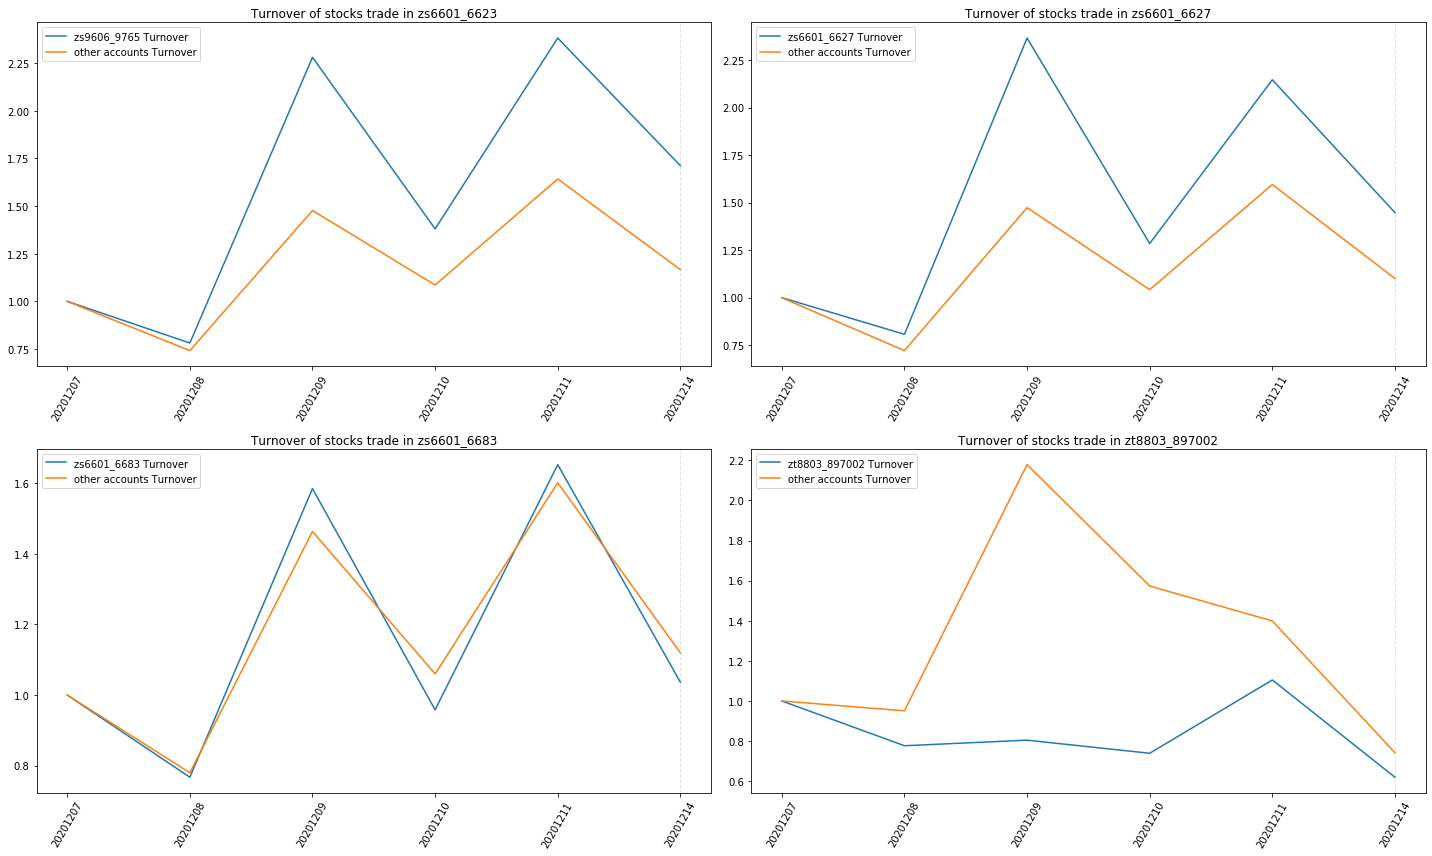

In [88]:
re2 = orderLog[(orderLog['updateType'] == 4)].groupby(['date', 'server_account'])['tradeNtl'].sum().reset_index()
re3 = orderLog[orderLog['updateType'] == 4]
re3 = pd.merge(re3, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zs6601_6623')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re3 = re3[re3['server_account'] != 'zs6601_6623']
re3 = re3.groupby(['date'])['tradeNtl'].sum().reset_index()


re4 = orderLog[orderLog['updateType'] == 4]
re4 = pd.merge(re4, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zs6601_6627')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re4 = re4[re4['server_account'] != 'zs6601_6627']
re4 = re4.groupby(['date'])['tradeNtl'].sum().reset_index()

re5 = orderLog[orderLog['updateType'] == 4]
re5 = pd.merge(re5, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zs6601_6683')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re5 = re5[re5['server_account'] != 'zs6601_6683']
re5 = re5.groupby(['date'])['tradeNtl'].sum().reset_index()

re6 = orderLog[orderLog['updateType'] == 4]
re6 = pd.merge(re6, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zt8803_897002')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re6 = re6[re6['server_account'] != 'zt8803_897002']
re6 = re6.groupby(['date'])['tradeNtl'].sum().reset_index()



fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(221)

ax.plot(re2[re2['server_account'] == 'zs6601_6623']['tradeNtl'].values/re2[re2['server_account'] == 'zs6601_6623']['tradeNtl'].values[0], label='zs9606_9765 Turnover')
ax.plot(re3['tradeNtl'].values/re3['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs6601_6623'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs6601_6623']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zs6601_6623')
plt.xticks(rotation=60)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)


ax = fig.add_subplot(222)


ax.plot((list(re2[re2['server_account'].isin(['zs6601_6627'])]['tradeNtl'].values))/re2[re2['server_account'].isin(['zs6601_6627'])]['tradeNtl'].values[0], label='zs6601_6627 Turnover')
ax.plot((list(re4['tradeNtl'].values))/re4['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs6601_6627'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs6601_6627']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zs6601_6627')
plt.xticks(rotation=60)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)

ax = fig.add_subplot(223)


ax.plot((list(re2[re2['server_account'].isin(['zs6601_6683'])]['tradeNtl'].values))/re2[re2['server_account'].isin(['zs6601_6683'])]['tradeNtl'].values[0], label='zs6601_6683 Turnover')
ax.plot((list(re5['tradeNtl'].values))/re5['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs6601_6683'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs6601_6683']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zs6601_6683')
plt.xticks(rotation=60)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)

ax = fig.add_subplot(224)


ax.plot((list(re2[re2['server_account'].isin(['zt8803_897002'])]['tradeNtl'].values))/re2[re2['server_account'].isin(['zt8803_897002'])]['tradeNtl'].values[0], label='zt8803_897002 Turnover')
ax.plot((list(re6['tradeNtl'].values))/re6['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zt8803_897002'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zt8803_897002']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zt8803_897002')
plt.xticks(rotation=60)
plt.axvline(x=5, ls="--",c="grey", alpha=0.2, lw=1)
plt.tight_layout()
plt.show()

In [86]:
(list(re6['tradeNtl'].values))/re6['tradeNtl'].values[0]

array([1.        , 0.95107704, 2.17873284, 1.57344046, 1.39922395,
       0.74198829])